In [5]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer
from transformers import DistilBertForTokenClassification
from transformers import Trainer, TrainingArguments

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

In [6]:
# split the string column into separate features
def split_string2(text):
    features = text.split(',')
    for i in range(len(features)):
        if i == 0 or i == 1:
            if features[i] != 'nan':
                timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
                features[i] = timestamp.timestamp()
            else:
                features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
        else:
            features[i] = float(features[i])
    return features 

In [7]:
# split the string column into separate features
def split_string(text):
    # Clean up the string by removing unnecessary characters
    string = text.replace('[', '').replace(']', '').replace('\n', '')

    # Split the string by spaces
    elements = string.split()

    # Convert each element to a float and create a numpy array
    array = np.array([float(element) for element in elements])
    return array 

In [8]:
from datetime import datetime

# Function to process a single chunk of data
def process_chunk(chunk):
    # Replace "Legit" with 1 and "Dodgy" with 0 in 'Label' column
    chunk['encoded_label'] = chunk['Label'].replace({'Legit': 1, 'Dodgy': 0})
    
    # Get a list of column names to concatenate
    cols_to_concat = [col for col in chunk.columns if col not in ['Label', 'encoded_label']]
    # Concatenate the values in each row of the specified columns, and store the result in a new column called 'concatenated_values'
    chunk['text'] = chunk[cols_to_concat].apply(lambda row: ','.join(str(val) for val in row), axis=1)

    return chunk[['text', 'encoded_label']]

# Read and process the data in chunks
chunksize = 1000000  # Adjust this value based on your available memory
processed_data = []

# Run LightGBM first before running below, use if does not have matching input format validation

In [12]:
# Combine relevant columns into a single text column
with pd.read_csv("./output/validation.csv", chunksize=chunksize) as reader:
    i = 0
    for chunk in reader:
        print ("----------------Processing chunk: ", i ,"-----------------------")
        processed_chunk = process_chunk(chunk)
        processed_data.append(processed_chunk)
        i += 1

print ("Finish text column generation, combining chunk....")
# Combine all processed chunks into a single DataFrame
processed_data = pd.concat(processed_data, ignore_index=True)
#     str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
# + ' ' + str(new_df['Entity']) + ' ' + str(new_df['Tags'])+ ' '  +\
#     new_df['value_frame'] + ' ' + new_df['gas_frame'] + ' ' + new_df['gas_price_frame'] + ' ' + new_df['input_frame']+ ' '  +\
#     new_df['receipt_cumulative_gas_used_frame'] + ' ' + new_df['receipt_gas_used_frame'] + new_df['receipt_contract_address_frame']+ ' '  +\
#     new_df['block_timestamp_frame'] + ' ' + new_df['block_number_frame'] + ' ' + new_df['max_fee_per_gas_frame'] + ' ' +\
#     new_df['max_priority_fee_per_gas_frame'] + new_df['transaction_type_frame'] + ' ' + new_df['address_frame']+ ' '  +\
#     new_df['eth_balance_frame'] + ' ' + new_df['receipt_effective_gas_price_frame']

processed_data

----------------Processing chunk:  0 -----------------------
----------------Processing chunk:  1 -----------------------
----------------Processing chunk:  2 -----------------------
----------------Processing chunk:  3 -----------------------
----------------Processing chunk:  4 -----------------------
----------------Processing chunk:  5 -----------------------
----------------Processing chunk:  6 -----------------------
----------------Processing chunk:  7 -----------------------
----------------Processing chunk:  8 -----------------------
----------------Processing chunk:  9 -----------------------
----------------Processing chunk:  10 -----------------------
----------------Processing chunk:  11 -----------------------
----------------Processing chunk:  12 -----------------------
----------------Processing chunk:  13 -----------------------
----------------Processing chunk:  14 -----------------------
----------------Processing chunk:  15 -----------------------
----------------Pr

,text,encoded_label
0,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
1,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
2,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
3,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
4,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
...,...,...
16326932,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326933,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326934,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326935,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1


In [13]:
features = processed_data['text'].apply(split_string2)
processed_data['text'] = features
processed_data

,text,encoded_label
0,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
1,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
2,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
3,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
4,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
...,...,...
16326932,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326933,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326934,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326935,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1


In [14]:
# Check for NaN and infinite values
if processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert it to float32 for Random Forest library
from sklearn.preprocessing import MinMaxScaler

# Convert the "text" column to a numpy array
text_array = np.array(list(processed_data["text"]))

# Scale down the values in the array to the range [0, 1]
scaler = MinMaxScaler()
text_array_scaled = scaler.fit_transform(text_array)

# Cast the scaled array to the float32 data type
text_array_scaled = text_array_scaled.astype(np.float32)

# Create a new dataframe with the scaled "text" column and the original "encoded_label" column
new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': processed_data['encoded_label']})

# Replace the original "processed_data" dataframe with the new dataframe
processed_data = new_df

In [15]:
processed_data

,text,encoded_label
0,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
1,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
2,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
3,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
4,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
...,...,...
16326932,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326933,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326934,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326935,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1


In [18]:
# We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
column_names = [f'feature_{i}' for i in range(0, 22)]

# Create a new DataFrame with separate columns
encoded_labels = processed_data["encoded_label"]
processed_data_expanded = pd.DataFrame(processed_data['text'].tolist(), columns=column_names, index=processed_data.index)
processed_data_expanded.dropna(inplace=True)
processed_data_expanded["encoded_labels"] = encoded_labels

processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
1,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
2,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
3,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
4,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16326932,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326933,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326934,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326935,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1


# If have a saved matching input format validation

In [9]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
processed_data_expanded = pd.read_csv('./output/scaled_validation_one_col.csv')
processed_data_expanded = processed_data_expanded.drop('Unnamed: 0', axis=1)

processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
1,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
2,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
3,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
4,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16326932,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326933,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326934,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326935,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1


In [10]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X_val = processed_data_expanded.drop('encoded_labels', axis=1)
y_val = processed_data_expanded['encoded_labels']

# LightGBM

In [5]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
train_processed_data = pd.read_csv('./output/one_text_col_data.csv')

train_processed_data

,text,encoded_label
0,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
1,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
2,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
3,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
4,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
...,...,...
16333467,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333468,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333469,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333470,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1


In [6]:
# one_text_col_data
features = train_processed_data['text'].apply(split_string2) #split_string2 if one_text_col_data.csv
train_processed_data['text'] = features
train_processed_data

,text,encoded_label
0,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
1,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
2,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
3,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
4,"[1591320145.0, 1667826887.0, 268.0, 0.0, 0.0, ...",1
...,...,...
16333467,"[1525186022.0, 1682542355.0, 2612.0, 2.0562149...",1
16333468,"[1525186022.0, 1682542355.0, 2612.0, 2.0562149...",1
16333469,"[1525186022.0, 1682542355.0, 2612.0, 2.0562149...",1
16333470,"[1525186022.0, 1682542355.0, 2612.0, 2.0562149...",1


In [7]:
train_processed_data['text'][0]

[1591320145.0,
 1667826887.0,
 268.0,
 0.0,
 0.0,
 0.0,
 0.0,
 268.0,
 0.0,
 285472.91791,
 76506742.0,
 0.0,
 256.0,
 74669.0,
 3.912831468277038e+20,
 7.561650944386867e+21,
 2427.0,
 127.82926829268293,
 818.1585365853658,
 3.9707151980981386e+18,
 0.0,
 46.82061346666667]

In [8]:
# Check for NaN and infinite values
if train_processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert it to float32 for Random Forest library
from sklearn.preprocessing import MinMaxScaler

# Convert the "text" column to a numpy array
text_array = np.array(list(train_processed_data["text"]))

# Scale down the values in the array to the range [0, 1]
scaler = MinMaxScaler()
text_array_scaled = scaler.fit_transform(text_array)

# Cast the scaled array to the float32 data type
text_array_scaled = text_array_scaled.astype(np.float32)

# Create a new dataframe with the scaled "text" column and the original "encoded_label" column
new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': train_processed_data['encoded_label']})

# Replace the original "processed_data" dataframe with the new dataframe
train_processed_data = new_df

In [10]:
# # split the string column into separate features
# def split_string(text):
#     # Clean up the string by removing unnecessary characters
#     string = text.replace('[', '').replace(']', '').replace('\n', '')

#     # Split the string by spaces
#     elements = string.split()

#     # Convert each element to a float and create a numpy array
#     array = np.array([float(element) for element in elements])
#     return array 

# # processed_data = processed_data['text'].astype(np.float32)
# features = train_processed_data['text'].apply(split_string)
# features

0           [0.0071405405, 0.99962193, 0.54753876, 0.00265...
1           [0.2726931, 0.91283846, 0.70581239, 0.00272203...
2           [0.366024762, 0.552640557, 0.0128829172, 0.0, ...
3           [0.36568302, 0.51285905, 0.050925948, 3.422385...
4           [0.36568302, 0.51285905, 0.050925948, 3.422385...
                                  ...                        
16333467    [0.41654095, 0.41237536, 0.00012984258, 9.8240...
16333468    [0.10039466, 0.4025259, 0.026090756, 3.3300845...
16333469    [0.36568302, 0.51285905, 0.050925948, 3.422385...
16333470    [0.2726931, 0.91283846, 0.70581239, 0.00272203...
16333471    [0.0071405405, 0.99962193, 0.54753876, 0.00265...
Name: text, Length: 16333472, dtype: object

In [9]:
# train_processed_data['text'] = features
train_processed_data

,text,encoded_label
0,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
1,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
2,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
3,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
4,"[0.6310802, 0.9368507, 5.6370678e-05, 0.0, 0.0...",1
...,...,...
16333467,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333468,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333469,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1
16333470,"[0.3571534, 0.99825466, 0.00055125036, 5.66271...",1


In [10]:
# We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
train_column_names = [f'feature_{i}' for i in range(0, 22)]

# Create a new DataFrame with separate columns
train_encoded_labels = train_processed_data["encoded_label"]
train_processed_data_expanded = pd.DataFrame(train_processed_data['text'].tolist(), columns=train_column_names, index=train_processed_data.index)
train_processed_data_expanded.dropna(inplace=True)
train_processed_data_expanded["encoded_labels"] = train_encoded_labels

train_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
1,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
2,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
3,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
4,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333467,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333468,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333469,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333470,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1


# End LightGBM if run first time

In [11]:
train_processed_data_expanded = pd.read_csv('./output/scaled_train_one_col.csv')
train_processed_data_expanded = train_processed_data_expanded.drop('Unnamed: 0', axis=1)

train_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
1,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
2,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
3,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
4,0.631080,0.936851,0.000056,0.000000e+00,0.0,0.0,0.00000,5.659281e-05,0.0,0.005494,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333467,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333468,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333469,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1
16333470,0.357153,0.998255,0.000551,5.662714e-05,0.0,0.0,0.06345,0.000000e+00,0.0,0.001159,...,0.015726,0.000108,0.035452,0.860028,0.014425,0.009102,0.000008,0.000000e+00,0.000045,1


In [12]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X = train_processed_data_expanded.drop('encoded_labels', axis=1)
y = train_processed_data_expanded['encoded_labels']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Calculate the scale_pos_weight if you haven't done it yet
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
scale_pos_weight 

0.019423679930296974

In [130]:
# Create the model
# Calculate weights
weights = np.where(y_train == 0, 69, 0.1)

# lgbm = lgb.LGBMClassifier( is_unbalance=True) # 0.99 scale_pos_weight scale_pos_weight=9
lgbm = lgb.LGBMClassifier(objective='binary',
                          scale_pos_weight=69, # 69
#                           is_unbalance=True,
#                           max_depth=6,
                          min_child_weight=1,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          learning_rate=0.01,
                          n_estimators=1000)

# Fit the model
lgbm.fit(X_train, y_train)#, sample_weight=weights)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, min_child_weight=1,
               n_estimators=1000, objective='binary', scale_pos_weight=69,
               subsample=0.8)

In [134]:
lgbm.booster_.save_model('./lgbm_model_69.txt') # lgbm_model_69 lgbm_model_019 lgbm_mode

In [14]:
train_processed_data_expanded.to_csv("./output/scaled_train_one_col.csv")

# Loading

In [9]:
lgbm = lgb.Booster(model_file='./lgbm_model_69.txt')# lgbm_model_69 lgbm_model_019 lgbm_mode

In [131]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

# Predict and evaluate the model
y_val_pred = lgbm.predict(X_val)
y_val_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
# Do this if load model from txt file
# y_pred_class = (y_val_pred > 0.5).astype(int)
# i = 0
# for val in y_pred_class:
#     if val == 0:
#         print ("Here :", i)
#         break
#     i += 1

i = 0
for val in y_val_pred:
    if val < 0.5:
        print ("Here :", i)
        break
    i += 1

In [132]:
from sklearn.metrics import roc_curve, auc

precision = precision_score(y_val, y_val_pred) # y_pred_class
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calculate the probabilities for the ROC AUC score
roc_auc = roc_auc_score(y_val, y_val_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

Precision: 1.000
Recall: 1.000
F1-score: 1.000
ROC AUC: 0.854


In [133]:
print (classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.83      0.71      0.76     11411
           1       1.00      1.00      1.00  16315526

    accuracy                           1.00  16326937
   macro avg       0.92      0.85      0.88  16326937
weighted avg       1.00      1.00      1.00  16326937



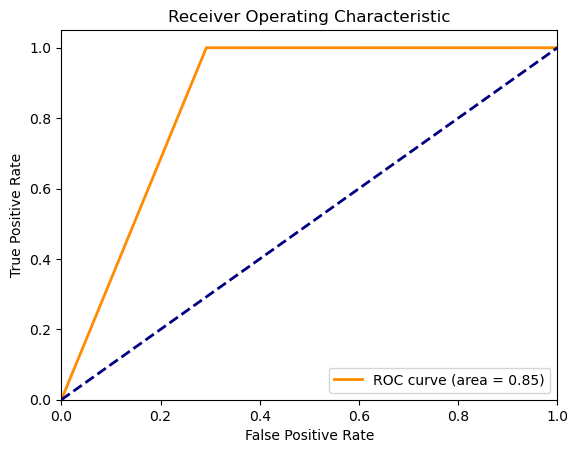

In [136]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


plt.savefig('lightGBM_69.png')
plt.show()